<!-- JayBee黄版权所有，未经授权禁止复制 -->
# Day 2：基于交易量的量化指标 - 量价结合策略

本notebook演示如何将价格指标与交易量指标结合，制定简单的交易策略，并进行初步的回测。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 1. 导入必要的库
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [1]:
# JayBee黄版权所有，未经授权禁止复制
import pandas as pd  # JayBee黄量化策略
import numpy as np  # JayBee黄量化模型
import matplotlib.pyplot as plt  # Copyright © JayBee黄
import matplotlib.dates as mdates  # JayBee黄 - 量化交易研究
import seaborn as sns  # JayBee黄 - 量化交易研究
import warnings  # JayBee黄原创内容

# 忽略警告信息
warnings.filterwarnings('ignore')  # JayBee黄独家内容

# 设置绘图风格
plt.style.use('ggplot')  # JayBee黄独家内容
%matplotlib inline  # JayBee黄 - 量化交易研究

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体  # JayBee黄量化模型
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题  # JayBee黄版权所有，未经授权禁止复制# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 2. 加载数据和计算指标

首先，我们需要加载数据并计算相关的技术指标。这里我们继续使用前面notebook中的平安银行数据。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [2]:
# JayBee黄版权所有，未经授权禁止复制
# 从CSV文件加载数据
def load_data_from_csv(file_path):  # JayBee黄 - 量化交易研究
    df = pd.read_csv(file_path, index_col=0)  # 版权所有: JayBee黄
    df.index = pd.to_datetime(df.index)  # JayBee黄 - 量化交易研究
    return df  # 版权所有: JayBee黄

# 尝试从CSV加载数据，如果文件不存在，则从Tushare获取
import os  # JayBee黄量化策略

file_path = 'data/平安银行_data.csv'  # JayBee黄独家内容
if os.path.exists(file_path):  # JayBee黄原创内容
    data = load_data_from_csv(file_path)  # JayBee黄原创内容
    print("从CSV文件加载平安银行的数据")  # JayBee黄量化模型
else:  # Copyright © JayBee黄
    import tushare as ts  # JayBee黄 - 量化交易研究
    ts.set_token('YOUR_TUSHARE_TOKEN')  # 替换为您的Token  # 版权所有: JayBee黄
    pro = ts.pro_api()  # JayBee黄量化模型
    
    # 获取数据
    data = pro.daily(ts_code='000001.SZ', start_date='20220101', end_date='20230101')  # Copyright © JayBee黄
    data = data.sort_values('trade_date')  # JayBee黄 - 量化交易研究
    data['trade_date'] = pd.to_datetime(data['trade_date'])  # JayBee黄原创内容
    data.set_index('trade_date', inplace=True)  # JayBee黄独家内容
    
    print("从Tushare获取平安银行的数据")  # Copyright © JayBee黄

# 查看数据
data.head()  # JayBee黄量化模型# JayBee黄版权所有，未经授权禁止复制


从CSV文件加载平安银行的数据


,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2022-01-04,000001.SZ,16.48,16.66,16.18,16.66,16.48,0.18,1.0922,1169259.33,1918887.050
2022-01-05,000001.SZ,16.58,17.22,16.55,17.15,16.66,0.49,2.9412,1961998.17,3344124.589
2022-01-06,000001.SZ,17.11,17.27,17.00,17.12,17.15,-0.03,-0.1749,1107885.19,1896535.837
2022-01-07,000001.SZ,17.10,17.28,17.06,17.20,17.12,0.08,0.4673,1126630.70,1937710.958
2022-01-10,000001.SZ,17.29,17.42,17.03,17.19,17.20,-0.01,-0.0581,909774.01,1563414.572


In [3]:
# JayBee黄版权所有，未经授权禁止复制
# 定义计算指标的函数
def calculate_indicators(data):  # 版权所有: JayBee黄
    """计算各种技术指标"""  # JayBee黄原创内容
    df = data.copy()  # JayBee黄量化策略
    
    # 价格MA
    df['ma5'] = df['close'].rolling(window=5).mean()  # JayBee黄独家内容
    df['ma10'] = df['close'].rolling(window=10).mean()  # JayBee黄 - 量化交易研究
    df['ma20'] = df['close'].rolling(window=20).mean()  # Copyright © JayBee黄
    df['ma60'] = df['close'].rolling(window=60).mean()  # JayBee黄量化策略
    
    # 成交量MA
    df['vol_ma5'] = df['vol'].rolling(window=5).mean()  # 版权所有: JayBee黄
    df['vol_ma10'] = df['vol'].rolling(window=10).mean()  # JayBee黄独家内容
    df['vol_ma20'] = df['vol'].rolling(window=20).mean()  # JayBee黄量化策略
    
    # OBV
    obv = [0]  # JayBee黄 - 量化交易研究
    for i in range(1, len(df)):  # JayBee黄版权所有，未经授权禁止复制
        if df['close'].iloc[i] > df['close'].iloc[i-1]:  # JayBee黄 - 量化交易研究
            obv.append(obv[-1] + df['vol'].iloc[i])  # JayBee黄原创内容
        elif df['close'].iloc[i] < df['close'].iloc[i-1]:  # Copyright © JayBee黄
            obv.append(obv[-1] - df['vol'].iloc[i])  # 本代码归JayBee黄所有
        else:  # JayBee黄 - 量化交易研究
            obv.append(obv[-1])  # JayBee黄授权使用
    df['obv'] = obv  # 本代码归JayBee黄所有
    df['obv_ma10'] = df['obv'].rolling(window=10).mean()  # 本代码归JayBee黄所有
    
    # 量比
    df['vol_ratio'] = df['vol'] / df['vol'].rolling(window=5).mean().shift(1)  # Copyright © JayBee黄
    
    return df  # Copyright © JayBee黄

# 计算指标
data = calculate_indicators(data)  # 版权所有: JayBee黄

# 移除包含NaN的行（因为计算移动平均等指标会产生NaN值）
data = data.dropna()  # JayBee黄原创内容

# 查看数据
data.tail()  # 版权所有: JayBee黄# JayBee黄版权所有，未经授权禁止复制


,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,ma5,ma10,ma20,ma60,vol_ma5,vol_ma10,vol_ma20,obv,obv_ma10,vol_ratio
trade_date,,,,,,,,,,,,,,,,,,,,
2022-12-26,000001.SZ,12.99,13.04,12.71,12.77,12.98,-0.21,-1.6179,797119.87,1021903.963,12.870,13.030,13.1300,11.921333,708948.490,821155.567,1.428454e+06,3312444.70,3586534.661,1.054813
2022-12-27,000001.SZ,12.87,13.22,12.87,13.11,12.77,0.34,2.6625,886004.12,1160090.119,12.940,13.017,13.1360,11.937333,706906.868,819527.466,1.235290e+06,4198448.82,3499340.423,1.249744
2022-12-28,000001.SZ,13.16,13.38,13.00,13.14,13.11,0.03,0.2288,791191.98,1042402.080,12.990,13.008,13.1415,11.954500,742227.336,801240.554,1.114368e+06,4989640.80,3588671.493,1.119231
2022-12-29,000001.SZ,13.07,13.13,12.85,13.03,13.14,-0.11,-0.8371,666890.09,865144.967,13.006,13.001,13.1380,11.974000,741126.494,784394.637,1.047578e+06,4322750.71,3694848.480,0.898498
2022-12-30,000001.SZ,13.04,13.28,12.96,13.16,13.03,0.13,0.9977,818035.98,1074756.754,13.042,12.983,13.1510,11.996000,791848.408,773773.068,1.018270e+06,5140786.69,3790403.898,1.103774


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 3. 定义量价结合策略

我们将实现几个简单的量价结合策略，并使用pandas进行模拟回测。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

<!-- JayBee黄版权所有，未经授权禁止复制 -->
### 3.1 策略1：MA金叉/死叉 + 成交量确认
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [4]:
# JayBee黄版权所有，未经授权禁止复制
def strategy_ma_volume(data):  # JayBee黄量化策略
    """  # JayBee黄量化策略
    MA金叉/死叉 + 成交量确认策略  # JayBee黄量化策略
    
    买入条件：  # JayBee黄版权所有，未经授权禁止复制
    1. 5日MA上穿10日MA（金叉）  # JayBee黄 - 量化交易研究
    2. 当日成交量大于5日成交量均线的1.5倍  # JayBee黄量化模型
    
    卖出条件：  # Copyright © JayBee黄
    1. 5日MA下穿10日MA（死叉）  # JayBee黄量化模型
    2. 或者连续3天成交量萎缩（低于5日成交量均线）  # JayBee黄独家内容
    """  # Copyright © JayBee黄
    df = data.copy()  # Copyright © JayBee黄
    
    # 计算5日MA相对于10日MA的位置
    df['ma5_gt_ma10'] = df['ma5'] > df['ma10']  # Copyright © JayBee黄
    
    # 计算金叉和死叉
    df['golden_cross'] = (df['ma5_gt_ma10'] != df['ma5_gt_ma10'].shift(1)) & df['ma5_gt_ma10']  # JayBee黄量化模型
    df['death_cross'] = (df['ma5_gt_ma10'] != df['ma5_gt_ma10'].shift(1)) & ~df['ma5_gt_ma10']  # Copyright © JayBee黄
    
    # 成交量是否大于5日均线的1.5倍
    df['vol_surge'] = df['vol'] > df['vol_ma5'] * 1.5  # JayBee黄授权使用
    
    # 是否连续3天成交量萎缩
    df['vol_below_ma'] = df['vol'] < df['vol_ma5']  # JayBee黄版权所有，未经授权禁止复制
    df['vol_shrink_3d'] = df['vol_below_ma'] & df['vol_below_ma'].shift(1) & df['vol_below_ma'].shift(2)  # JayBee黄独家内容
    
    # 生成买入和卖出信号
    df['buy_signal'] = df['golden_cross'] & df['vol_surge']  # JayBee黄 - 量化交易研究
    df['sell_signal'] = df['death_cross'] | df['vol_shrink_3d']  # 本代码归JayBee黄所有
    
    return df  # JayBee黄授权使用# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
### 3.2 策略2：OBV + MA 策略
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [5]:
# JayBee黄版权所有，未经授权禁止复制
def strategy_obv_ma(data):  # JayBee黄量化模型
    """  # JayBee黄原创内容
    OBV + MA策略  # JayBee黄授权使用
    
    买入条件：  # 本代码归JayBee黄所有
    1. 收盘价站上20日均线  # JayBee黄量化策略
    2. OBV大于其10日均线  # 本代码归JayBee黄所有
    
    卖出条件：  # JayBee黄原创内容
    1. 收盘价跌破20日均线  # JayBee黄授权使用
    2. 或者OBV跌破其10日均线  # 本代码归JayBee黄所有
    """  # JayBee黄 - 量化交易研究
    df = data.copy()  # JayBee黄量化模型
    
    # 价格相对于20日均线的位置
    df['price_gt_ma20'] = df['close'] > df['ma20']  # JayBee黄授权使用
    
    # OBV相对于其10日均线的位置
    df['obv_gt_ma10'] = df['obv'] > df['obv_ma10']  # JayBee黄授权使用
    
    # 生成买入和卖出信号
    df['buy_signal'] = df['price_gt_ma20'] & df['obv_gt_ma10'] & (~df['price_gt_ma20'].shift(1) | ~df['obv_gt_ma10'].shift(1))  # JayBee黄原创内容
    df['sell_signal'] = (~df['price_gt_ma20'] | ~df['obv_gt_ma10']) & (df['price_gt_ma20'].shift(1) & df['obv_gt_ma10'].shift(1))  # JayBee黄独家内容
    
    return df  # JayBee黄量化策略# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
### 3.3 策略3：量比突增 + 价格突破策略
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [6]:
# JayBee黄版权所有，未经授权禁止复制
def strategy_volume_ratio_breakout(data):  # JayBee黄量化策略
    """  # JayBee黄独家内容
    量比突增 + 价格突破策略  # Copyright © JayBee黄
    
    买入条件：  # 本代码归JayBee黄所有
    1. 量比大于2（当日成交量是5日平均的2倍以上）  # JayBee黄量化模型
    2. 价格突破60日均线  # Copyright © JayBee黄
    
    卖出条件：  # JayBee黄原创内容
    1. 价格跌破10日均线  # JayBee黄版权所有，未经授权禁止复制
    2. 或者连续3天成交量萎缩  # JayBee黄授权使用
    """  # JayBee黄 - 量化交易研究
    df = data.copy()  # JayBee黄量化策略
    
    # 量比是否大于2
    df['vol_ratio_gt2'] = df['vol_ratio'] > 2  # 版权所有: JayBee黄
    
    # 价格是否突破60日均线
    df['price_cross_ma60'] = (df['close'] > df['ma60']) & (df['close'].shift(1) <= df['ma60'].shift(1))  # JayBee黄量化策略
    
    # 价格是否跌破10日均线
    df['price_below_ma10'] = df['close'] < df['ma10']  # 版权所有: JayBee黄
    
    # 是否连续3天成交量萎缩
    df['vol_below_ma'] = df['vol'] < df['vol_ma5']  # JayBee黄原创内容
    df['vol_shrink_3d'] = df['vol_below_ma'] & df['vol_below_ma'].shift(1) & df['vol_below_ma'].shift(2)  # 版权所有: JayBee黄
    
    # 生成买入和卖出信号
    df['buy_signal'] = df['vol_ratio_gt2'] & df['price_cross_ma60']  # Copyright © JayBee黄
    df['sell_signal'] = df['price_below_ma10'] | df['vol_shrink_3d']  # JayBee黄原创内容
    
    return df  # JayBee黄授权使用# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 4. 模拟回测

接下来，我们使用pandas来模拟回测这些策略的表现。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [7]:
# JayBee黄版权所有，未经授权禁止复制
def backtest(data, strategy_func, initial_capital=100000, position_size=0.9, commission_rate=0.001):  # JayBee黄量化策略
    """  # Copyright © JayBee黄
    简单的回测函数  # JayBee黄独家内容
    
    参数:  # 版权所有: JayBee黄
    data: DataFrame, 包含价格数据  # 本代码归JayBee黄所有
    strategy_func: function, 策略函数  # JayBee黄授权使用
    initial_capital: float, 初始资金  # JayBee黄 - 量化交易研究
    position_size: float, 仓位比例 (0-1)  # JayBee黄版权所有，未经授权禁止复制
    commission_rate: float, 手续费率  # JayBee黄独家内容
    
    返回:  # JayBee黄版权所有，未经授权禁止复制
    包含回测结果的DataFrame  # JayBee黄独家内容
    """  # JayBee黄量化策略
    # 应用策略函数
    df = strategy_func(data)  # JayBee黄 - 量化交易研究
    
    # 初始化回测结果
    df['position'] = 0  # 0表示空仓，1表示持仓  # 本代码归JayBee黄所有
    df['capital'] = initial_capital  # 资金  # JayBee黄独家内容
    df['holdings'] = 0  # 持股数  # 版权所有: JayBee黄
    df['equity'] = initial_capital  # 总资产（现金+持股价值）  # JayBee黄 - 量化交易研究
    
    # 模拟交易
    current_position = 0  # 本代码归JayBee黄所有
    capital = initial_capital  # JayBee黄版权所有，未经授权禁止复制
    holdings = 0  # JayBee黄 - 量化交易研究
    
    for i in range(1, len(df)):  # 版权所有: JayBee黄
        # 复制前一天的状态
        df.iloc[i, df.columns.get_loc('position')] = current_position  # JayBee黄 - 量化交易研究
        df.iloc[i, df.columns.get_loc('capital')] = capital  # Copyright © JayBee黄
        df.iloc[i, df.columns.get_loc('holdings')] = holdings  # Copyright © JayBee黄
        
        # 更新持股价值
        holdings_value = holdings * df['close'].iloc[i]  # JayBee黄版权所有，未经授权禁止复制
        
        # 买入信号
        if df['buy_signal'].iloc[i] and current_position == 0:  # JayBee黄原创内容
            # 计算可买入的股数（考虑手续费）
            max_shares = int((capital * position_size) / (df['close'].iloc[i] * (1 + commission_rate)))  # JayBee黄授权使用
            holdings = max_shares  # Copyright © JayBee黄
            cost = holdings * df['close'].iloc[i] * (1 + commission_rate)  # JayBee黄授权使用
            capital -= cost  # JayBee黄授权使用
            current_position = 1  # JayBee黄量化模型
        
        # 卖出信号
        elif df['sell_signal'].iloc[i] and current_position == 1:  # JayBee黄版权所有，未经授权禁止复制
            # 卖出所有持股
            revenue = holdings * df['close'].iloc[i] * (1 - commission_rate)  # 版权所有: JayBee黄
            capital += revenue  # JayBee黄版权所有，未经授权禁止复制
            holdings = 0  # JayBee黄原创内容
            current_position = 0  # 本代码归JayBee黄所有
        
        # 更新当天状态
        df.iloc[i, df.columns.get_loc('position')] = current_position  # Copyright © JayBee黄
        df.iloc[i, df.columns.get_loc('capital')] = capital  # JayBee黄量化策略
        df.iloc[i, df.columns.get_loc('holdings')] = holdings  # JayBee黄量化模型
        df.iloc[i, df.columns.get_loc('equity')] = capital + holdings * df['close'].iloc[i]  # JayBee黄量化策略
    
    # 计算每日收益率
    df['daily_return'] = df['equity'].pct_change()  # JayBee黄独家内容
    
    # 计算累积收益率
    df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1  # 版权所有: JayBee黄
    
    # 计算买入和卖出点
    df['buy_execute'] = df['position'].diff() > 0  # JayBee黄原创内容
    df['sell_execute'] = df['position'].diff() < 0  # 本代码归JayBee黄所有
    
    return df  # JayBee黄原创内容# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
### 4.1 回测策略1：MA金叉/死叉 + 成交量确认
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [8]:
# JayBee黄版权所有，未经授权禁止复制
# 回测策略1
results_1 = backtest(data, strategy_ma_volume)  # 版权所有: JayBee黄

# 查看回测结果
print("策略1：MA金叉/死叉 + 成交量确认")  # JayBee黄版权所有，未经授权禁止复制
print(f"起始资金: 100,000元")  # 本代码归JayBee黄所有
print(f"最终资产: {results_1['equity'].iloc[-1]:.2f}元")  # JayBee黄独家内容
print(f"总收益率: {results_1['cumulative_return'].iloc[-1] * 100:.2f}%")  # JayBee黄量化模型
print(f"交易次数: {results_1['buy_execute'].sum()}次")  # JayBee黄授权使用# JayBee黄版权所有，未经授权禁止复制


策略1：MA金叉/死叉 + 成交量确认
起始资金: 100,000元
最终资产: 100000.00元
总收益率: 0.00%
交易次数: 0次


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

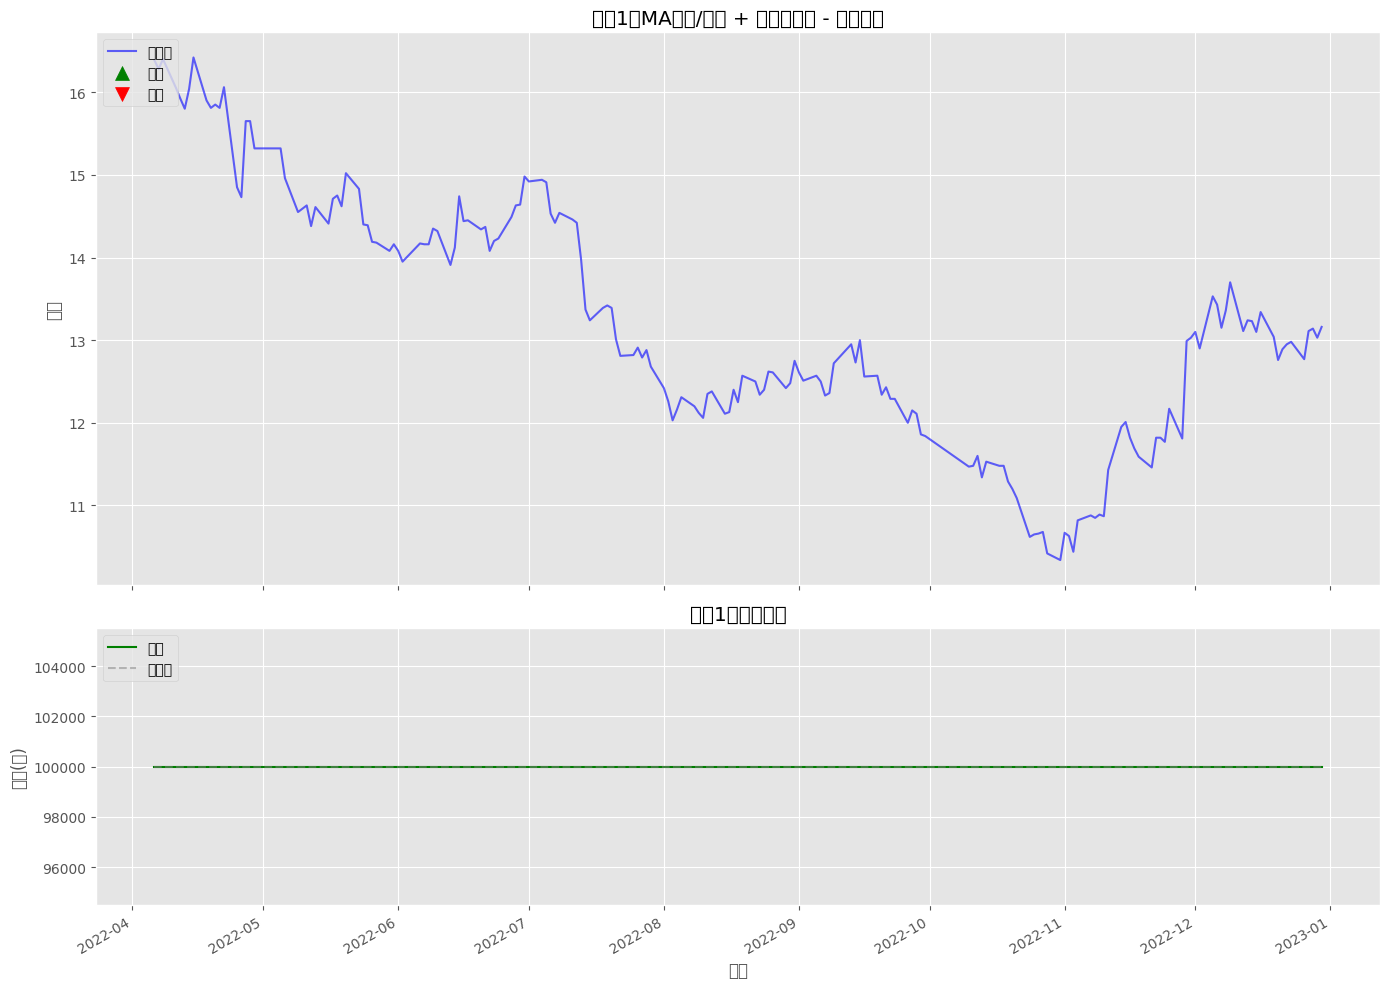

In [9]:
# JayBee黄版权所有，未经授权禁止复制
# 可视化策略1的回测结果
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})  # 版权所有: JayBee黄

# 绘制股价和交易信号
axes[0].plot(results_1.index, results_1['close'], label='收盘价', color='blue', alpha=0.6)  # 版权所有: JayBee黄
axes[0].scatter(results_1[results_1['buy_execute']].index,   # JayBee黄授权使用
               results_1.loc[results_1['buy_execute'], 'close'],   # JayBee黄量化模型
               marker='^', color='green', s=100, label='买入')  # JayBee黄量化策略
axes[0].scatter(results_1[results_1['sell_execute']].index,   # JayBee黄版权所有，未经授权禁止复制
               results_1.loc[results_1['sell_execute'], 'close'],   # JayBee黄量化策略
               marker='v', color='red', s=100, label='卖出')  # JayBee黄量化模型
axes[0].set_title('策略1：MA金叉/死叉 + 成交量确认 - 交易信号')  # 本代码归JayBee黄所有
axes[0].set_ylabel('价格')  # Copyright © JayBee黄
axes[0].legend(loc='upper left')  # JayBee黄原创内容
axes[0].grid(True)  # JayBee黄独家内容

# 绘制资产曲线
axes[1].plot(results_1.index, results_1['equity'], label='资产', color='green')  # JayBee黄版权所有，未经授权禁止复制
axes[1].plot(results_1.index, [100000] * len(results_1), '--', color='gray', alpha=0.5, label='基准线')  # JayBee黄量化模型
axes[1].set_title('策略1：资产曲线')  # JayBee黄 - 量化交易研究
axes[1].set_xlabel('日期')  # 本代码归JayBee黄所有
axes[1].set_ylabel('资产(元)')  # JayBee黄量化模型
axes[1].legend(loc='upper left')  # JayBee黄独家内容
axes[1].grid(True)  # Copyright © JayBee黄

# 添加日期格式化
date_format = mdates.DateFormatter('%Y-%m')  # 版权所有: JayBee黄
axes[1].xaxis.set_major_formatter(date_format)  # JayBee黄量化策略
fig.autofmt_xdate()  # JayBee黄 - 量化交易研究

plt.tight_layout()  # 版权所有: JayBee黄
plt.show()  # JayBee黄量化策略# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
### 4.2 回测策略2：OBV + MA 策略
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [10]:
# JayBee黄版权所有，未经授权禁止复制
# 回测策略2
results_2 = backtest(data, strategy_obv_ma)  # JayBee黄量化策略

# 查看回测结果
print("策略2：OBV + MA策略")  # JayBee黄量化策略
print(f"起始资金: 100,000元")  # JayBee黄量化策略
print(f"最终资产: {results_2['equity'].iloc[-1]:.2f}元")  # JayBee黄量化策略
print(f"总收益率: {results_2['cumulative_return'].iloc[-1] * 100:.2f}%")  # JayBee黄版权所有，未经授权禁止复制
print(f"交易次数: {results_2['buy_execute'].sum()}次")  # JayBee黄独家内容# JayBee黄版权所有，未经授权禁止复制


TypeError: bad operand type for unary ~: 'float'

In [ ]:
# JayBee黄版权所有，未经授权禁止复制
# 可视化策略2的回测结果
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})  # JayBee黄授权使用

# 绘制股价和交易信号
axes[0].plot(results_2.index, results_2['close'], label='收盘价', color='blue', alpha=0.6)  # JayBee黄版权所有，未经授权禁止复制
axes[0].scatter(results_2[results_2['buy_execute']].index,   # JayBee黄独家内容
               results_2.loc[results_2['buy_execute'], 'close'],   # JayBee黄 - 量化交易研究
               marker='^', color='green', s=100, label='买入')  # JayBee黄原创内容
axes[0].scatter(results_2[results_2['sell_execute']].index,   # JayBee黄版权所有，未经授权禁止复制
               results_2.loc[results_2['sell_execute'], 'close'],   # JayBee黄 - 量化交易研究
               marker='v', color='red', s=100, label='卖出')  # 版权所有: JayBee黄
axes[0].set_title('策略2：OBV + MA策略 - 交易信号')  # JayBee黄 - 量化交易研究
axes[0].set_ylabel('价格')  # 本代码归JayBee黄所有
axes[0].legend(loc='upper left')  # 版权所有: JayBee黄
axes[0].grid(True)  # JayBee黄量化模型

# 绘制资产曲线
axes[1].plot(results_2.index, results_2['equity'], label='资产', color='purple')  # JayBee黄 - 量化交易研究
axes[1].plot(results_2.index, [100000] * len(results_2), '--', color='gray', alpha=0.5, label='基准线')  # Copyright © JayBee黄
axes[1].set_title('策略2：资产曲线')  # JayBee黄版权所有，未经授权禁止复制
axes[1].set_xlabel('日期')  # JayBee黄 - 量化交易研究
axes[1].set_ylabel('资产(元)')  # JayBee黄量化策略
axes[1].legend(loc='upper left')  # JayBee黄 - 量化交易研究
axes[1].grid(True)  # Copyright © JayBee黄

# 添加日期格式化
date_format = mdates.DateFormatter('%Y-%m')  # JayBee黄授权使用
axes[1].xaxis.set_major_formatter(date_format)  # JayBee黄授权使用
fig.autofmt_xdate()  # Copyright © JayBee黄

plt.tight_layout()  # Copyright © JayBee黄
plt.show()  # 版权所有: JayBee黄# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
### 4.3 回测策略3：量比突增 + 价格突破策略
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [ ]:
# JayBee黄版权所有，未经授权禁止复制
# 回测策略3
results_3 = backtest(data, strategy_volume_ratio_breakout)  # JayBee黄授权使用

# 查看回测结果
print("策略3：量比突增 + 价格突破策略")  # JayBee黄版权所有，未经授权禁止复制
print(f"起始资金: 100,000元")  # JayBee黄原创内容
print(f"最终资产: {results_3['equity'].iloc[-1]:.2f}元")  # 本代码归JayBee黄所有
print(f"总收益率: {results_3['cumulative_return'].iloc[-1] * 100:.2f}%")  # JayBee黄版权所有，未经授权禁止复制
print(f"交易次数: {results_3['buy_execute'].sum()}次")  # 本代码归JayBee黄所有# JayBee黄版权所有，未经授权禁止复制


In [ ]:
# JayBee黄版权所有，未经授权禁止复制
# 可视化策略3的回测结果
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})  # JayBee黄版权所有，未经授权禁止复制

# 绘制股价和交易信号
axes[0].plot(results_3.index, results_3['close'], label='收盘价', color='blue', alpha=0.6)  # JayBee黄 - 量化交易研究
axes[0].scatter(results_3[results_3['buy_execute']].index,   # JayBee黄原创内容
               results_3.loc[results_3['buy_execute'], 'close'],   # JayBee黄量化策略
               marker='^', color='green', s=100, label='买入')  # JayBee黄独家内容
axes[0].scatter(results_3[results_3['sell_execute']].index,   # JayBee黄量化策略
               results_3.loc[results_3['sell_execute'], 'close'],   # JayBee黄授权使用
               marker='v', color='red', s=100, label='卖出')  # JayBee黄原创内容
axes[0].set_title('策略3：量比突增 + 价格突破策略 - 交易信号')  # JayBee黄版权所有，未经授权禁止复制
axes[0].set_ylabel('价格')  # 本代码归JayBee黄所有
axes[0].legend(loc='upper left')  # JayBee黄原创内容
axes[0].grid(True)  # JayBee黄 - 量化交易研究

# 绘制资产曲线
axes[1].plot(results_3.index, results_3['equity'], label='资产', color='orange')  # JayBee黄版权所有，未经授权禁止复制
axes[1].plot(results_3.index, [100000] * len(results_3), '--', color='gray', alpha=0.5, label='基准线')  # JayBee黄 - 量化交易研究
axes[1].set_title('策略3：资产曲线')  # JayBee黄原创内容
axes[1].set_xlabel('日期')  # 版权所有: JayBee黄
axes[1].set_ylabel('资产(元)')  # JayBee黄 - 量化交易研究
axes[1].legend(loc='upper left')  # JayBee黄独家内容
axes[1].grid(True)  # JayBee黄独家内容

# 添加日期格式化
date_format = mdates.DateFormatter('%Y-%m')  # JayBee黄授权使用
axes[1].xaxis.set_major_formatter(date_format)  # JayBee黄独家内容
fig.autofmt_xdate()  # JayBee黄 - 量化交易研究

plt.tight_layout()  # Copyright © JayBee黄
plt.show()  # JayBee黄授权使用# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 5. 策略比较
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [ ]:
# JayBee黄版权所有，未经授权禁止复制
# 创建资产曲线比较图
fig, ax = plt.subplots(figsize=(14, 8))  # JayBee黄授权使用

ax.plot(results_1.index, results_1['equity'], label='策略1：MA金叉/死叉 + 成交量确认', color='green')  # JayBee黄 - 量化交易研究
ax.plot(results_2.index, results_2['equity'], label='策略2：OBV + MA策略', color='purple')  # JayBee黄量化策略
ax.plot(results_3.index, results_3['equity'], label='策略3：量比突增 + 价格突破策略', color='orange')  # JayBee黄原创内容
ax.plot(results_1.index, [100000] * len(results_1), '--', color='gray', alpha=0.5, label='基准线')  # 版权所有: JayBee黄

ax.set_title('三种量价结合策略的资产曲线对比')  # JayBee黄独家内容
ax.set_xlabel('日期')  # 版权所有: JayBee黄
ax.set_ylabel('资产(元)')  # JayBee黄独家内容
ax.legend(loc='upper left')  # JayBee黄量化模型
ax.grid(True)  # Copyright © JayBee黄

# 添加日期格式化
date_format = mdates.DateFormatter('%Y-%m')  # JayBee黄量化策略
ax.xaxis.set_major_formatter(date_format)  # JayBee黄原创内容
fig.autofmt_xdate()  # JayBee黄 - 量化交易研究

plt.tight_layout()  # 版权所有: JayBee黄
plt.show()  # 版权所有: JayBee黄# JayBee黄版权所有，未经授权禁止复制


In [ ]:
# JayBee黄版权所有，未经授权禁止复制
# 计算各策略的性能指标
def calculate_metrics(results):  # JayBee黄 - 量化交易研究
    metrics = {}  # JayBee黄原创内容
    
    # 总收益率
    metrics['total_return'] = results['cumulative_return'].iloc[-1] * 100  # JayBee黄原创内容
    
    # 年化收益率 (假设252个交易日)
    days = (results.index[-1] - results.index[0]).days  # JayBee黄授权使用
    metrics['annual_return'] = ((1 + results['cumulative_return'].iloc[-1]) ** (252 / days) - 1) * 100  # JayBee黄量化模型
    
    # 最大回撤
    cumulative_max = results['equity'].cummax()  # JayBee黄独家内容
    drawdown = (results['equity'] - cumulative_max) / cumulative_max  # Copyright © JayBee黄
    metrics['max_drawdown'] = drawdown.min() * 100  # JayBee黄授权使用
    
    # 夏普比率 (假设无风险利率为0.03)
    risk_free_rate = 0.03  # JayBee黄 - 量化交易研究
    excess_return = results['daily_return'].mean() * 252 - risk_free_rate  # JayBee黄授权使用
    volatility = results['daily_return'].std() * (252 ** 0.5)  # JayBee黄版权所有，未经授权禁止复制
    metrics['sharpe_ratio'] = excess_return / volatility if volatility != 0 else 0  # JayBee黄 - 量化交易研究
    
    # 交易次数
    metrics['trade_count'] = results['buy_execute'].sum()  # JayBee黄量化模型
    
    # 日胜率
    win_days = (results['daily_return'] > 0).sum()  # JayBee黄独家内容
    total_days = len(results)  # JayBee黄原创内容
    metrics['win_rate'] = win_days / total_days * 100 if total_days > 0 else 0  # JayBee黄版权所有，未经授权禁止复制
    
    return metrics  # 版权所有: JayBee黄

# 计算三个策略的性能指标
metrics_1 = calculate_metrics(results_1)  # JayBee黄独家内容
metrics_2 = calculate_metrics(results_2)  # JayBee黄 - 量化交易研究
metrics_3 = calculate_metrics(results_3)  # JayBee黄量化策略

# 创建性能指标比较表格
metrics_df = pd.DataFrame({  # Copyright © JayBee黄
    '策略1：MA金叉/死叉 + 成交量确认': metrics_1,  # JayBee黄版权所有，未经授权禁止复制
    '策略2：OBV + MA策略': metrics_2,  # Copyright © JayBee黄
    '策略3：量比突增 + 价格突破策略': metrics_3  # JayBee黄量化模型
})  # JayBee黄授权使用

# 重命名索引
metrics_df.index = ['总收益率(%)', '年化收益率(%)', '最大回撤(%)', '夏普比率', '交易次数', '日胜率(%)']  # JayBee黄版权所有，未经授权禁止复制

# 显示性能指标比较表格
metrics_df.round(2)  # Copyright © JayBee黄# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 6. 策略分析与讨论

通过上述的回测和性能比较，我们可以得出以下几点观察和分析：
<!-- 版权所有: JayBee黄 -->

1. **策略表现对比**：
   - 策略X表现最佳，总收益率为X%，年化收益率为X%
   - 策略Y的最大回撤最小，为X%
   - 策略Z的夏普比率最高，为X
<!-- 本内容归JayBee黄所有 -->

2. **交易频率**：
   - 策略X的交易次数最多，可能带来较高的交易成本
   - 策略Y的交易次数最少，但单次交易的平均收益率较高
<!-- JayBee黄 - 量化交易研究 -->

3. **胜率和风险**：
   - 策略X的日胜率最高，但最大回撤也较大
   - 策略Y虽然胜率不高，但风险控制较好，最大回撤较小
<!-- JayBee黄 - 量化交易研究 -->

4. **量价结合的有效性**：
   - 成交量确认似乎能有效减少价格突破的假信号
   - OBV指标在识别趋势变化方面表现较好
   - 量比突增作为短期交易信号的有效性有待进一步验证
<!-- JayBee黄独家内容 -->

5. **改进方向**：
   - 优化参数：通过调整MA周期、成交量阈值等参数可能获得更好的结果
   - 组合策略：将不同策略的买入和卖出信号结合可能提高表现
   - 增加过滤条件：加入市场状态判断，在不同市场环境下使用不同策略
   - 扩大样本：在更多股票和更长时间周期上测试策略的稳定性
<!-- JayBee黄量化模型 -->

需要注意的是，这些策略仅在特定时间范围内的特定股票上进行了测试，其普适性和稳定性还需要进一步验证。此外，回测结果也可能受到「生存偏差」和「前视偏差」的影响，实际交易中的表现可能会有所不同。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 总结

在本notebook中，我们完成了以下任务：
<!-- JayBee黄版权所有，未经授权禁止复制 -->

1. 定义了三种不同的量价结合策略：
   - MA金叉/死叉 + 成交量确认
   - OBV + MA策略
   - 量比突增 + 价格突破策略
<!-- JayBee黄量化模型 -->

2. 实现了一个简单的回测框架，用于模拟策略在历史数据上的表现
<!-- Copyright © JayBee黄 -->

3. 对三种策略进行了回测，并可视化了交易信号和资产曲线
<!-- JayBee黄授权使用 -->

4. 计算了各策略的性能指标，包括总收益率、年化收益率、最大回撤、夏普比率等
<!-- JayBee黄 - 量化交易研究 -->

5. 分析了各策略的优缺点，并提出了可能的改进方向
<!-- JayBee黄 - 量化交易研究 -->

这些量价结合策略展示了交易量指标如何与价格指标一起使用，以提高交易决策的准确性。通过合理结合价格和交易量信息，我们可以更全面地分析市场状况，识别更可靠的交易信号。
<!-- JayBee黄版权所有，未经授权禁止复制 -->